📂 Please upload the 'risk_factors_cervical_cancer.csv' file downloaded from Kaggle:


Saving risk_factors_cervical_cancer.csv to risk_factors_cervical_cancer.csv

✅ File 'risk_factors_cervical_cancer.csv' uploaded successfully!


/tmp/ipython-input-1766751986.py:39: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
2025/11/20 20:52:20 INFO mlflow.tracking.fluent: Experiment with name '/Users/agolabi3@asu.edu/CervicalCancer_FinalProject' does not exist. Creating a new experiment.


Tracking URI: databricks
Experiment:  /Users/agolabi3@asu.edu/CervicalCancer_FinalProject

📊 Random Forest Results
--------------------
Accuracy : 0.953
Precision: 0.714
Recall   : 0.455
F1 Score : 0.556

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       161
           1       0.71      0.45      0.56        11

    accuracy                           0.95       172
   macro avg       0.84      0.72      0.77       172
weighted avg       0.95      0.95      0.95       172



2025/11/20 20:52:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 20:52:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest_CervicalCancer at: https://dbc-9db5c046-87aa.cloud.databricks.com/ml/experiments/2748764736454961/runs/4ae04d1cc3eb40c58ed0182c0e9a6d89
🧪 View experiment at: https://dbc-9db5c046-87aa.cloud.databricks.com/ml/experiments/2748764736454961

📊 Logistic Regression Results
--------------------
Accuracy : 0.959
Precision: 0.700
Recall   : 0.636
F1 Score : 0.667

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       161
           1       0.70      0.64      0.67        11

    accuracy                           0.96       172
   macro avg       0.84      0.81      0.82       172
weighted avg       0.96      0.96      0.96       172



2025/11/20 20:52:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 20:52:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression_CervicalCancer at: https://dbc-9db5c046-87aa.cloud.databricks.com/ml/experiments/2748764736454961/runs/380f891ae8f34f238851601215bf4a99
🧪 View experiment at: https://dbc-9db5c046-87aa.cloud.databricks.com/ml/experiments/2748764736454961


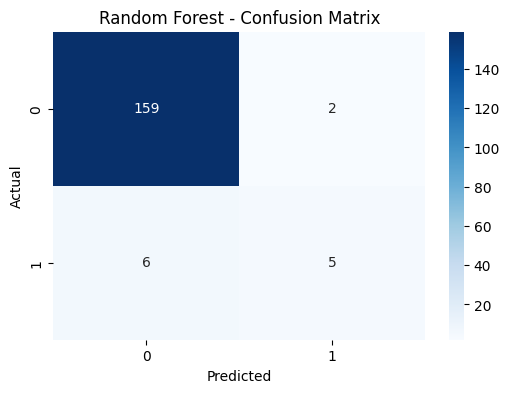


💾 Best model saved as 'cervical_rf_model.pkl'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ NOTE:
In this healthcare context, RECALL (sensitivity) is the most critical metric.
It measures how many actual cancer cases the model correctly identifies.
Prioritizing recall helps minimize false negatives (missed diagnoses),
even if it slightly increases false positives.



In [ ]:
# ==========================================================
# CIS 508 Final Project - Cervical Cancer Risk Prediction
# Google Colab + Databricks MLflow
# ==========================================================

# --- 0. Install dependencies (run once) ---
!pip install -q mlflow databricks-sdk seaborn joblib

# --- 1. Imports ---
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import mlflow
import mlflow.sklearn
from google.colab import files

# --- 2. Upload the Dataset ---
print("📂 Please upload the 'risk_factors_cervical_cancer.csv' file downloaded from Kaggle:")
uploaded = files.upload()

filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)
print(f"\n✅ File '{filename}' uploaded successfully!")

# --- 3. Data Cleaning ---
df.replace('?', np.nan, inplace=True)
df = df.apply(pd.to_numeric, errors='ignore')
df.dropna(subset=['Biopsy'], inplace=True)

X = df.drop(columns=['Biopsy'])
y = df['Biopsy']

imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# --- 4. Split and Scale ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- 5. Configure Databricks MLflow Tracking ---
try:
    from google.colab import userdata
    os.environ["DATABRICKS_HOST"]  = userdata.get("DATABRICKS_HOST")
    os.environ["DATABRICKS_TOKEN"] = userdata.get("DATABRICKS_TOKEN")
except Exception as e:
    print("⚠️ Could not load Colab userdata secrets. Make sure DATABRICKS_HOST and DATABRICKS_TOKEN are set.")
    print(e)

mlflow.set_tracking_uri("databricks")

# You can change this to any experiment path you want in Databricks
experiment_name = "/Users/agolabi3@asu.edu/CervicalCancer_FinalProject"
mlflow.set_experiment(experiment_name)

print("Tracking URI:", mlflow.get_tracking_uri())
print("Experiment: ", experiment_name)

# --- 6. Helper: Evaluate and Print Metrics ---
def evaluate_model(name, y_true, y_pred):
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec  = recall_score(y_true, y_pred)
    f1   = f1_score(y_true, y_pred)
    print(f"\n📊 {name} Results")
    print("--------------------")
    print(f"Accuracy : {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall   : {rec:.3f}")
    print(f"F1 Score : {f1:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    return acc, prec, rec, f1

# --- 7. Train + Log Random Forest to Databricks ---
with mlflow.start_run(run_name="RandomForest_CervicalCancer"):
    rf = RandomForestClassifier(
        random_state=42,
        n_estimators=200,
        max_depth=None
    )
    rf.fit(X_train, y_train)
    rf_preds = rf.predict(X_test)

    rf_acc, rf_prec, rf_rec, rf_f1 = evaluate_model("Random Forest", y_test, rf_preds)

    # Log params & metrics
    mlflow.log_param("model_type", "RandomForestClassifier")
    mlflow.log_param("n_estimators", rf.n_estimators)
    mlflow.log_param("max_depth", rf.max_depth)
    mlflow.log_metric("accuracy", rf_acc)
    mlflow.log_metric("precision", rf_prec)
    mlflow.log_metric("recall", rf_rec)
    mlflow.log_metric("f1_score", rf_f1)

    # Log model
    mlflow.sklearn.log_model(rf, artifact_path="model")

# --- 8. Train + Log Logistic Regression to Databricks ---
with mlflow.start_run(run_name="LogisticRegression_CervicalCancer"):
    logreg = LogisticRegression(max_iter=1000)
    logreg.fit(X_train, y_train)
    log_preds = logreg.predict(X_test)

    log_acc, log_prec, log_rec, log_f1 = evaluate_model("Logistic Regression", y_test, log_preds)

    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("max_iter", logreg.max_iter)
    mlflow.log_metric("accuracy", log_acc)
    mlflow.log_metric("precision", log_prec)
    mlflow.log_metric("recall", log_rec)
    mlflow.log_metric("f1_score", log_f1)

    mlflow.sklearn.log_model(logreg, artifact_path="model")

# --- 9. Confusion Matrix for Best Model (assume RF) ---
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, fmt="d", cmap="Blues")
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- 10. Save and Download Best Model Locally (for Streamlit) ---
joblib.dump(rf, "cervical_rf_model.pkl")
print("\n💾 Best model saved as 'cervical_rf_model.pkl'.")
files.download("cervical_rf_model.pkl")

# --- 11. Interpretation Note ---
print("""
✅ NOTE:
In this healthcare context, RECALL (sensitivity) is the most critical metric.
It measures how many actual cancer cases the model correctly identifies.
Prioritizing recall helps minimize false negatives (missed diagnoses),
even if it slightly increases false positives.
""")
